<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U pip
!pip install -U japanize_matplotlib

     |████████████████████████████████| 1.6MB 5.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 4.1 MB 4.9 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=3c42fd7551d9b4abd356768ee274eb4b82c26c78cf413d7b8366e9ce905d104c
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [2]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import re
from pytz import timezone
from tqdm.notebook import tqdm

%matplotlib inline

### COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19/blob/development/FORKED_SITES.md

In [3]:
urls = {
    'tokyo': 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json',
#     'saitama': 'https://raw.githubusercontent.com/codefortoda/covid19-saitama/development/data/data.json',
    'aichi': 'https://raw.githubusercontent.com/code4nagoya/covid19/development/data/data.json',
#     'osaka': 'https://raw.githubusercontent.com/codeforosaka/covid19/development/data/data.json',
    'hyogo': 'https://raw.githubusercontent.com/stop-covid19-hyogo/covid19/development/data/patients_summary.json',
    'fukui': 'https://raw.githubusercontent.com/nomunomu0504/covid19/nomu_development/data/patients_summary.json',
    'tottori': 'https://raw.githubusercontent.com/tottori-covid19/covid19/master/data/data.json',
    'shimane': 'https://raw.githubusercontent.com/TaigaMikami/shimane-covid19/shimane/data/patients_summary.json',
    'okinawa': 'https://raw.githubusercontent.com/Code-for-OKINAWA/covid19/development/data/data.json',
    'fukuoka': 'https://raw.githubusercontent.com/Code-for-Fukuoka/covid19-fukuoka/development/data/data.json',
    'hokkaido': 'https://stopcovid19.hokkaido.dev/api/patients_summary.json',
#     'kanagawa': 'https://www.pref.kanagawa.jp/osirase/1369/data/data.json',
    ##'chiba': 'https://raw.githubusercontent.com/civictechzenchiba/covid19-chiba/development/data/data.json',
    #'hiroshima': 'https://raw.githubusercontent.com/tatsuya1970/covid19/development/data/data.json',
    'fukushima': 'https://cdn2.dott.dev/data.json',
#     'chiba': 'https://covid19chiba.s3-ap-northeast-1.amazonaws.com/DataPub.json',
    'shizuokashi': 'https://db7rdtcq3byow.cloudfront.net/data.json',
    'hamamatsushi': 'https://raw.githubusercontent.com/code-for-hamamatsu/covid19/dev-hamamatsu/data/hamamatsu/data.json',
    'shiga': 'https://shiga-pref-org.github.io/covid19-data/data.json',
}

In [4]:
def get_json_data(pref: str, url: str) -> dict:
    response = requests.get(url)
    json_data = json.loads(response.text)
    
    # json文字列をdictへ
    if pref == 'shimane':
        return json_data['patients_summary']
    if pref == 'hokkaido':
        return {'data': [{'日付': j['日付'], '小計': j['日陽性数']} for j in json_data['data']]}
    if pref == 'kanagawa':
        print(json_data['patient'])
#     print(json_data['patients_summary']['data'])
    return json_data

In [5]:
#res = get_json_data('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
#print(type(res))
#res

In [6]:
def datetime_to_date(datestr: str) -> datetime:
    return datetime.datetime.strptime(re.sub(r'T.*$', '', datestr), '%Y-%m-%d')

In [7]:
def utc_datestr_to_jst_date(datestr: str) -> datetime:
   return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  #return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [8]:
#utc_datestr_to_jst_date('2020-08-12T12:34:56.789Z')

In [9]:
def get_patients_count(json_data: dict, file_name: str) -> list:
    if file_name == 'data.json':
        return [data['小計'] for data in json_data['patients_summary']['data']]
    return [data['小計'] for data in json_data['data']]

In [10]:
def get_df_index(json_data: dict, file_name: str):
    if file_name == 'data.json':
        return [datetime_to_date(d['日付']) for d in json_data['patients_summary']['data']]
#         return pd.date_range(
#             start=datetime_to_date(json_data['patients_summary']['data'][0]['日付']),
#             end=datetime_to_date(json_data['patients_summary']['data'][-1]['日付']),
#             freq='D')
    return [datetime_to_date(d['日付']) for d in json_data['data']]
#     return pd.date_range(
#             start=datetime_to_date(json_data['data'][0]['日付']),
#             end=datetime_to_date(json_data['data'][-1]['日付']),
#             freq='D')

In [11]:
def get_data(pref: str, url: str):
    json_data = get_json_data(pref, url)
#     print(json_data)
    file_name = url.split('/')[-1]

    # 日毎の数
    patients_count = get_patients_count(json_data, file_name)
    # dataframe index
    df_index = get_df_index(json_data, file_name)

    # データフレームにセット（インデックスに日付をセット）
    df = pd.DataFrame({'patients_count': patients_count}, index=df_index)
    # 7日間移動平均・合計カラムを追加
    try:
        df['7d_mov_ave'] = df['patients_count'].rolling('7D').mean()
        df['7d_mov_sum'] = df['patients_count'].rolling('7D').sum()
    except Exception as e:
        print(e)
        df['7d_mov_ave'] = np.zeros(len(df['patients_count']))
        df['7d_mov_sum'] = np.zeros(len(df['patients_count']))
        
    return df

In [12]:
# url = urls['tottori']
# print(url)
# res = get_data(url)
# print(type(res))
# print(res.tail(15))

In [13]:
for k, v in tqdm(urls.items()):
    print(k, v)
    res = get_data(k, v)
    #res = get_data('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
    #res = get_data('https://raw.githubusercontent.com/stop-covid19-hyogo/covid19/development/data/patients_summary.json')
    print(type(res))
    print(res.tail(15))
    print('-----')

tokyo https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json
<class 'pandas.core.frame.DataFrame'>
            patients_count  7d_mov_ave  7d_mov_sum
2021-05-18             732  756.857143      5298.0
2021-05-19             766  727.857143      5095.0
2021-05-20             843  704.000000      4928.0
2021-05-21             649  674.714286      4723.0
2021-05-22             602  650.428571      4553.0
2021-05-23             535  649.428571      4546.0
2021-05-24             340  638.142857      4467.0
2021-05-25             542  611.000000      4277.0
2021-05-26             743  607.714286      4254.0
2021-05-27             684  585.000000      4095.0
2021-05-28             614  580.000000      4060.0
2021-05-29             539  571.000000      3997.0
2021-05-30             448  558.571429      3910.0
2021-05-31             260  547.142857      3830.0
2021-06-01             471  537.000000      3759.0
-----
aichi https://raw.githubusercontent.com/co

In [14]:
def week_num(d: datetime) -> str:
    return f'\'{d.strftime("%y")}w{d.strftime("%V")}'

In [15]:
def week_num_list(l: list) -> list:
    return [week_num(d) for d in l]

In [16]:
def week_day(d: datetime) -> str:
    return d.strftime('%a')

In [17]:
def week_day_list(l: list) -> list:
    return [week_day(d) for d in l]

In [18]:
# res = pd.DataFrame({
#     'week_num': week_num_list([(datetime.datetime(2020,1,1) + datetime.timedelta(i)) for i in range(370)]),
#     'week_day': week_day_list([(datetime.datetime(2020,1,1) + datetime.timedelta(i)) for i in range(370)])
# })
# print(type(res))
# res

In [19]:
def get_df(pref: str, url: str):
    df = get_data(pref, url)
    # 日付カラムを追加
    df['datetime'] = df.index
    # 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
    df['week_num'] = week_num_list(df.index)
    # 曜日の列をセット
    df['week_day'] = week_day_list(df.index)
    return df

In [20]:
#res = get_df('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
#print(type(res))
#res

In [21]:
def agg_df(df):
    # 週毎に集計
    groupby_week_num = df.groupby('week_num')
    # 集計結果から平均と合計を取得しデータフレームにセット
    return pd.DataFrame({
        'week_num': df['week_num'].unique(),
        'week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
        'week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
    }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])

In [22]:
# res = agg_df(get_df('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'))
# print(type(res))
# res

In [23]:
dfs = {}
weekly_agg_dfs = {}
for k, v in tqdm(urls.items()):
    df = get_df(k, v)
    weekly_agg_df = agg_df(df)
    # 集計カラムを追加
    df = pd.concat([
        df, weekly_agg_df.loc[:, ['week_mean', 'week_sum']]
    ], axis=1)
    dfs[k] = df
#     weekly_agg_dfs[item[0]] = weekly_agg_df

#print(min([len(v) for k, v in dfs.items()]))
#print(weekly_agg_dfs)

In [24]:
pd.DataFrame({k: dfs[k]['patients_count'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,tottori,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-05-18,732,NaN,249.0,2.0,0.0,NaN,168.0,NaN,533.0,43.0,14.0,NaN,NaN
2021-05-19,766,NaN,242.0,9.0,0.0,NaN,203.0,NaN,603.0,35.0,10.0,NaN,NaN
2021-05-20,843,NaN,207.0,4.0,0.0,NaN,198.0,NaN,681.0,33.0,20.0,NaN,NaN
2021-05-21,649,NaN,161.0,3.0,2.0,NaN,207.0,NaN,727.0,26.0,16.0,NaN,NaN
2021-05-22,602,NaN,227.0,6.0,0.0,NaN,231.0,NaN,658.0,21.0,19.0,NaN,NaN
2021-05-23,535,NaN,110.0,3.0,2.0,NaN,156.0,NaN,605.0,22.0,14.0,NaN,NaN
2021-05-24,340,NaN,86.0,4.0,3.0,NaN,104.0,NaN,366.0,13.0,6.0,NaN,NaN
2021-05-25,542,NaN,139.0,3.0,3.0,NaN,256.0,NaN,459.0,28.0,14.0,NaN,NaN
2021-05-26,743,NaN,140.0,7.0,0.0,NaN,302.0,NaN,551.0,18.0,16.0,NaN,NaN
2021-05-27,684,NaN,162.0,0.0,0.0,NaN,240.0,NaN,570.0,15.0,10.0,NaN,NaN


In [25]:
pd.DataFrame({k: dfs[k]['7d_mov_ave'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,tottori,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-05-18,756.857143,NaN,283.857143,4.714286,0.714286,NaN,119.142857,NaN,542.285714,38.571429,17.857143,NaN,NaN
2021-05-19,727.857143,NaN,264.000000,5.857143,0.714286,NaN,132.571429,NaN,552.857143,36.000000,16.142857,NaN,NaN
2021-05-20,704.000000,NaN,242.285714,5.142857,0.714286,NaN,142.857143,NaN,548.428571,35.142857,14.857143,NaN,NaN
2021-05-21,674.714286,NaN,220.428571,4.714286,0.714286,NaN,153.285714,NaN,567.571429,30.142857,15.000000,NaN,NaN
2021-05-22,650.428571,NaN,210.285714,4.285714,0.714286,NaN,163.428571,NaN,580.714286,28.714286,14.428571,NaN,NaN
2021-05-23,649.428571,NaN,188.000000,4.428571,0.714286,NaN,174.571429,NaN,597.000000,28.571429,14.714286,NaN,NaN
2021-05-24,638.142857,NaN,183.142857,4.428571,1.000000,NaN,181.000000,NaN,596.142857,27.571429,14.142857,NaN,NaN
2021-05-25,611.000000,NaN,167.428571,4.571429,1.428571,NaN,193.571429,NaN,585.571429,25.428571,14.142857,NaN,NaN
2021-05-26,607.714286,NaN,152.857143,4.285714,1.428571,NaN,207.714286,NaN,578.142857,23.000000,15.000000,NaN,NaN
2021-05-27,585.000000,NaN,146.428571,3.714286,1.428571,NaN,213.714286,NaN,562.285714,20.428571,13.571429,NaN,NaN


In [26]:
pd.DataFrame({k: dfs[k]['7d_mov_sum'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,tottori,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-05-18,5298.0,NaN,1987.0,33.0,5.0,NaN,834.0,NaN,3796.0,270.0,125.0,NaN,NaN
2021-05-19,5095.0,NaN,1848.0,41.0,5.0,NaN,928.0,NaN,3870.0,252.0,113.0,NaN,NaN
2021-05-20,4928.0,NaN,1696.0,36.0,5.0,NaN,1000.0,NaN,3839.0,246.0,104.0,NaN,NaN
2021-05-21,4723.0,NaN,1543.0,33.0,5.0,NaN,1073.0,NaN,3973.0,211.0,105.0,NaN,NaN
2021-05-22,4553.0,NaN,1472.0,30.0,5.0,NaN,1144.0,NaN,4065.0,201.0,101.0,NaN,NaN
2021-05-23,4546.0,NaN,1316.0,31.0,5.0,NaN,1222.0,NaN,4179.0,200.0,103.0,NaN,NaN
2021-05-24,4467.0,NaN,1282.0,31.0,7.0,NaN,1267.0,NaN,4173.0,193.0,99.0,NaN,NaN
2021-05-25,4277.0,NaN,1172.0,32.0,10.0,NaN,1355.0,NaN,4099.0,178.0,99.0,NaN,NaN
2021-05-26,4254.0,NaN,1070.0,30.0,10.0,NaN,1454.0,NaN,4047.0,161.0,105.0,NaN,NaN
2021-05-27,4095.0,NaN,1025.0,26.0,10.0,NaN,1496.0,NaN,3936.0,143.0,95.0,NaN,NaN


In [27]:
for k, v in tqdm(dfs.items()):
    print(k)
    print(v[['week_day', 'patients_count', '7d_mov_ave', '7d_mov_sum']].tail(15))
    print('---')

tokyo
           week_day  patients_count  7d_mov_ave  7d_mov_sum
2021-05-18      Tue             732  756.857143      5298.0
2021-05-19      Wed             766  727.857143      5095.0
2021-05-20      Thu             843  704.000000      4928.0
2021-05-21      Fri             649  674.714286      4723.0
2021-05-22      Sat             602  650.428571      4553.0
2021-05-23      Sun             535  649.428571      4546.0
2021-05-24      Mon             340  638.142857      4467.0
2021-05-25      Tue             542  611.000000      4277.0
2021-05-26      Wed             743  607.714286      4254.0
2021-05-27      Thu             684  585.000000      4095.0
2021-05-28      Fri             614  580.000000      4060.0
2021-05-29      Sat             539  571.000000      3997.0
2021-05-30      Sun             448  558.571429      3910.0
2021-05-31      Mon             260  547.142857      3830.0
2021-06-01      Tue             471  537.000000      3759.0
---
aichi
           week_day  pat

In [28]:
titles = ['daily count', '7days mean', '7days sum']
x = list(dfs.items())[0][1].index

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


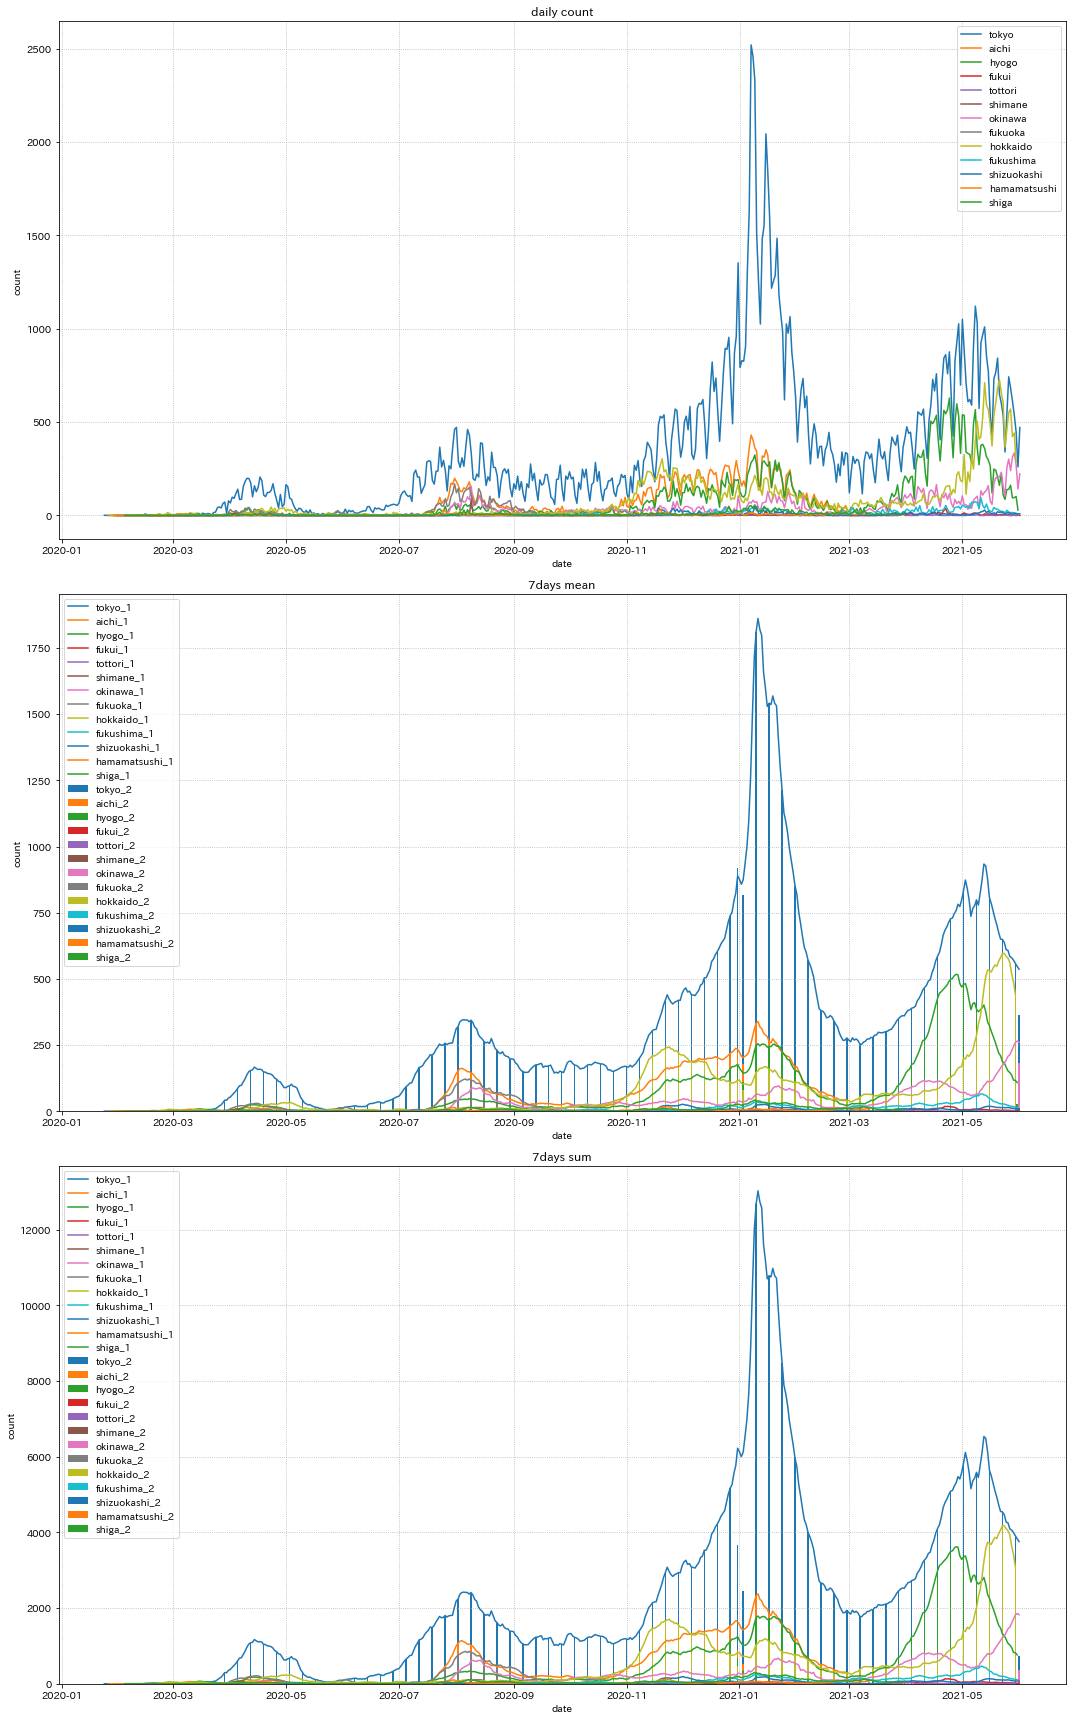

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(15, 24))

for k, v in tqdm(dfs.items()):
    x = v.index
    y1 = v['patients_count']
    ax[0].plot(x, y1, label=k)
    
    y2_1 = v['7d_mov_ave']
    ax[1].plot(x, y2_1, label=f"{k}_1")
    y2_2 = v['week_mean']
    ax[1].bar(x, y2_2, label=f"{k}_2")
    
    y3_1 = v['7d_mov_sum']
    ax[2].plot(x, y3_1, label=f"{k}_1")
    y3_2 = v['week_sum']
    ax[2].bar(x, y3_2, label=f"{k}_2")

for i, _ax in tqdm(enumerate(ax)):
    _ax.set_title(titles[i])
    _ax.set_xlabel('date')
    _ax.set_ylabel('count')
    _ax.grid(linestyle=':')
    _ax.legend()

plt.tight_layout()